In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')

In [ ]:
df.isnull().values.any()

np.False_

In [ ]:
LABELS = ["Normal", "Fraud"]

/tmp/ipython-input-2107955042.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


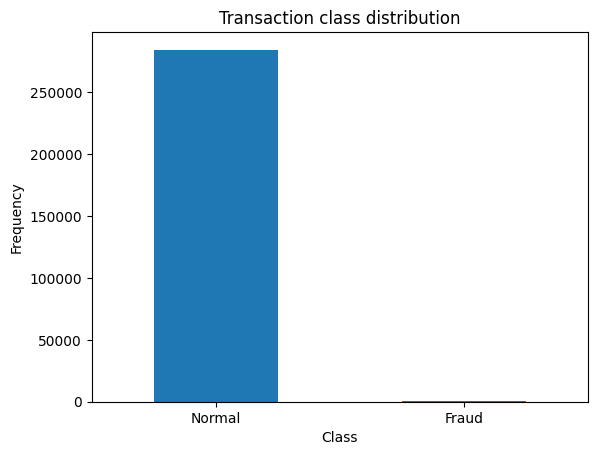

In [ ]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [ ]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [ ]:
normal.shape

(284315, 31)

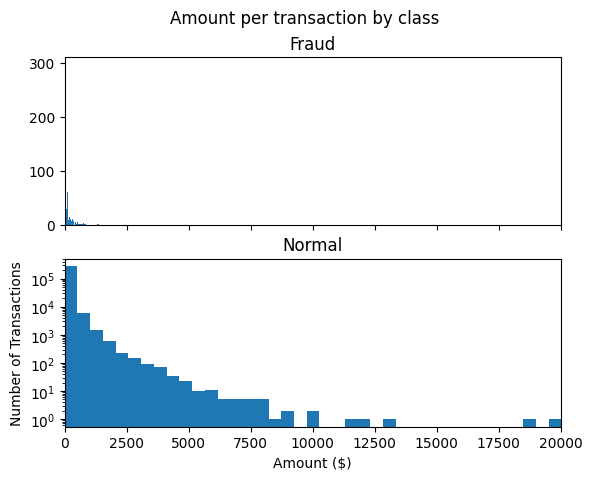

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

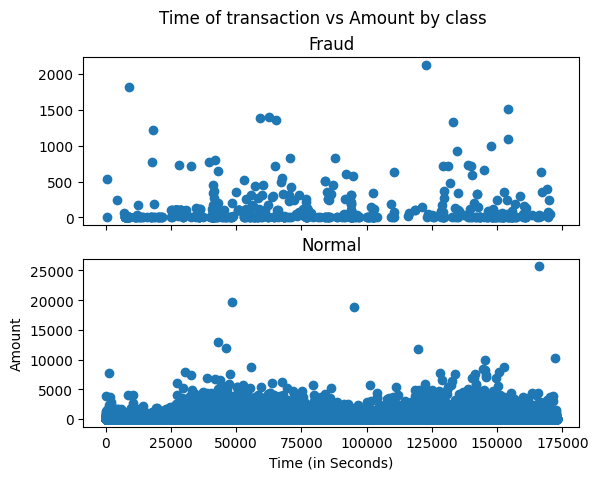

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [ ]:
RANDOM_SEED = 42
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(227451, 29)

In [ ]:
# 오토인코더 모델

input_dim = X_train.shape[1]
encoding_dim = 14  # 인코딩 차원을 설정 (임의로 설정한 값, 조정 가능)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
# 3. 모델 학습
# 훈련데이터의 0.1 을 validation data로 사용
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_split = 0.1)

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1143 - val_loss: 0.9250
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9316 - val_loss: 0.8849
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8998 - val_loss: 0.8649
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8830 - val_loss: 0.8579
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8768 - val_loss: 0.8505
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8588 - val_loss: 0.8434
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8707 - val_loss: 0.8398
Epoch 8/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8547 - val_loss: 0.8357
Epoch 9/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8575 - val_loss: 0.8333
Epoch 10/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8367 - val_loss: 0.8305
Epoch 11/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8410 - val_loss: 0.8287
Epoch 12/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

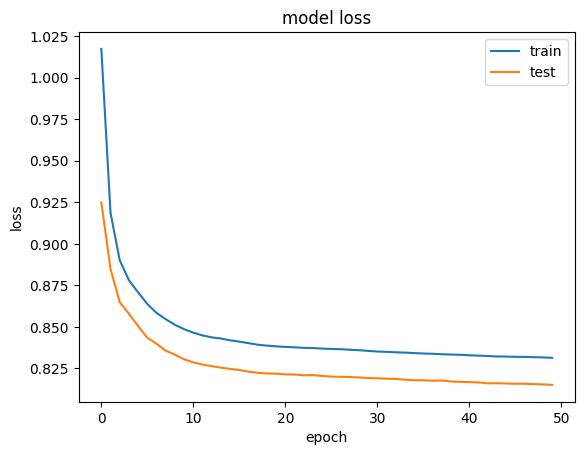

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [ ]:
# X_test 값을 넣어서 Reconstruction Error 값을 얻고,
# 실제 레이블인 y_test와 데이터프레임으로 구성
# Reconstruction Error + 실제 레이블의 형태가 됨

predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.857565,0.001720
std,3.740243,0.041443
min,0.048609,0.000000
25%,0.260295,0.000000
50%,0.446349,0.000000
75%,0.714470,0.000000
max,263.914537,1.000000


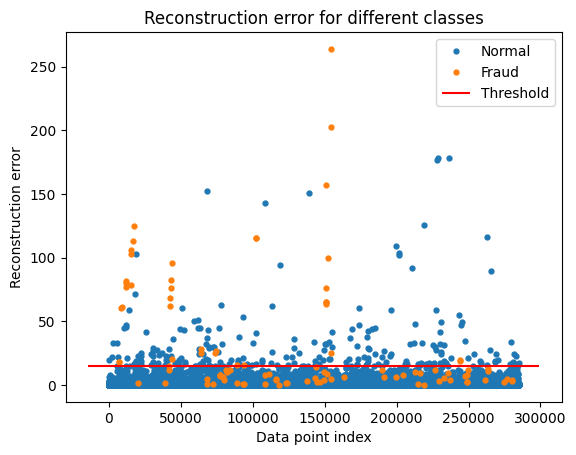

In [ ]:
# threshold 값을 조정하여 최선의 정확도를 얻음, 그래프로를 보고 결정

threshold = 15

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

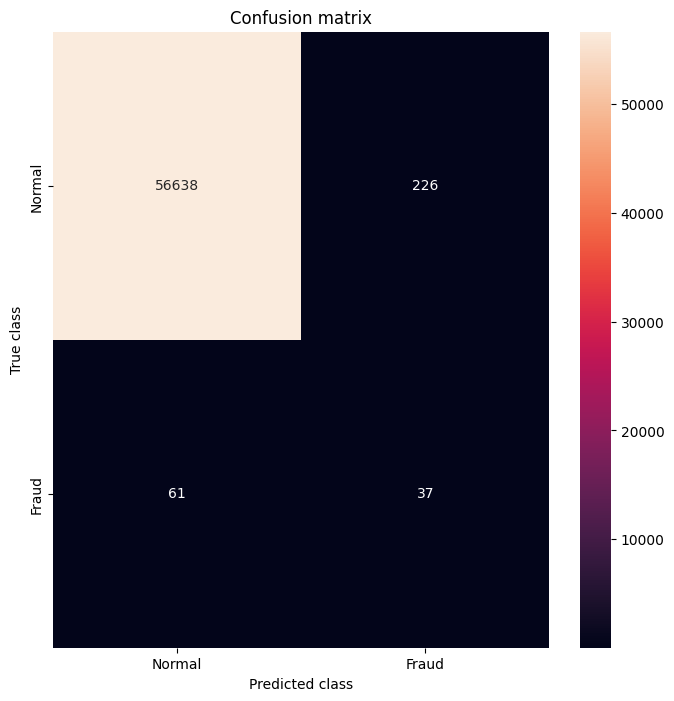

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.14      0.38      0.20        98

    accuracy                           0.99     56962
   macro avg       0.57      0.69      0.60     56962
weighted avg       1.00      0.99      1.00     56962



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred))